<a href="https://colab.research.google.com/github/linshaochieh2019/test/blob/main/rsna_3DCNN_pytorch_nobbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchio
!pip install pytorch-lightning
#!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D
#!pip install 'neptune-client[pytorch-lightning]'

     |████████████████████████████████| 156 kB 7.2 MB/s 
     |████████████████████████████████| 48.4 MB 11 kB/s 
     |████████████████████████████████| 925 kB 7.6 MB/s 
     |████████████████████████████████| 636 kB 68.3 MB/s 
     |████████████████████████████████| 829 kB 59.4 MB/s 
     |████████████████████████████████| 125 kB 57.6 MB/s 
     |████████████████████████████████| 282 kB 80.4 MB/s 
     |████████████████████████████████| 1.3 MB 28.3 MB/s 
     |████████████████████████████████| 271 kB 78.4 MB/s 
     |████████████████████████████████| 160 kB 65.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6f00ab1bb8cd66a2e4e7baac6314cb9fbde789319ac982fe8c076f621bc2f7cd
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled P

In [2]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import packages
import sys
import pytorch_lightning as pl

import torch
from torch import nn
import torch.nn.functional as F

#from efficientnet_pytorch_3d import EfficientNet3D

In [8]:
# Get dataloaders

if __name__ == '__main__':

  # Load dataset
  sys.path.append('/content/drive/MyDrive/Colab Notebooks/RSNA/Dataset')

  from rsnapre_bbox_v3 import RSNAPre
  dataset = RSNAPre(data_dir='/content/drive/MyDrive/Data/rsna_practice')
  dataset.setup()
  train_loader = dataset.train_dataloader()
  val_loader = dataset.val_dataloader()

  #save dataloaders
  #loader_dir = '/content/drive/MyDrive/Colab Notebooks/RSNA/loaders/'
  #train_loader_path = loader_dir + 'train_loader_v3.pth'
  #val_loader_path = loader_dir + 'val_loader_v3.pth'
  #torch.save(train_loader, train_loader_path)
  #torch.save(val_loader, val_loader_path)

In [ ]:
# load dataloader
#loader_dir = '/content/drive/MyDrive/Colab Notebooks/RSNA/loaders/'
#val_loader_path = loader_dir + 'val_loader_v3.pth'
#train_loader_path = loader_dir + 'train_loader_v3.pth'
#train_loader = torch.load(train_loader_path)
#val_loader = torch.load(val_loader_path)

In [ ]:
#from neptune.new.integrations.pytorch_lightning import NeptuneLogger

#neptune_logger = NeptuneLogger(
#            api_key='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZWQzMTYwZC1iOTU5LTQxN2UtYTg2My1iNjkxN2NjNWU4NGMifQ==',
#            project="linshaochieh2019/test", 
#            name='lightning-run',  # Optional
#        )

In [57]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer1 = self._conv_layer_set(1, 3)
        self.conv_layer2 = self._conv_layer_set(3, 9)
        self.fc1 = nn.Linear(10584, 128)
        self.fc2 = nn.Linear(128, 8)
        self.fc3 = nn.Linear(8, 1) #n_class = 1 as a binary classification problem.
        self.relu = nn.LeakyReLU()
        self.batch1=nn.BatchNorm1d(128)
        self.batch2=nn.BatchNorm1d(8)
        self.drop=nn.Dropout(p=0.15) 
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch1(out)
        out = self.drop(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.batch2(out)
        out = self.drop(out)
        
        out = self.fc3(out)
        
        return out

In [59]:
# Load model and device
#model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 1}, in_channels=1)
model = CNNModel()
model.cuda()

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
def prepare_batch(batch):
    # Get inputs: only the central slices from T2w

    #input_flair = batch['FLAIR']['data'][:,:,24:40].float().to(device)
    #input_t1w = batch['T1w']['data']
    #input_t1wce = batch['T1wCE']['data'][:,:,24:40].float().to(device)
    input_t2w = batch['T2w']['data'][:,:,:,:,16:48].float().to(device)

    # Concat inputs
    #ls_input = [input_flair, input_t1wce]
    #input_cat = torch.cat(ls_input, dim=4)

    # Get label
    label = batch['MGMT_value'].view(-1,1).float().to(device)
    return input_t2w, label

In [ ]:
from tqdm import tqdm

# Initiate training stats
train_stats = {'train_loss': [],
               'val_loss': [] 
               }

best_loss = 1

for epoch_i in tqdm(range(200)):

  # switch to train mode
  model.train()
  train_loss = 0

  for batch in tqdm(train_loader):
    input_cat, label = prepare_batch(batch)
    logits = model(input_cat)
    loss = criterion(logits, label)
    train_loss += loss.item()
    
    # compute gradient and do optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss = train_loss / len(train_loader)
  print('train_loss: {:.4f}.'.format(train_loss))

  # switch to evaluate mode
  model.eval()
  val_loss = 0

  with torch.no_grad():
    for batch in tqdm(val_loader):
      input_cat, label = prepare_batch(batch)
      logits = model(input_cat)
      loss = criterion(logits, label)
      val_loss += loss.item()
      scheduler.step(val_loss)

  val_loss = val_loss / len(val_loader)
  print('val_loss: {:.4f}'.format(val_loss))

  if val_loss < best_loss:
    print('Best loss updated')
    print('Previous val_loss: {:.4f}'.format(best_loss))

    best_loss = val_loss
    PATH = '/content/drive/MyDrive/Colab Notebooks/RSNA/weights/exp9.pt'
    torch.save(model.state_dict(), PATH)
  
  # record loss
  train_stats['train_loss'].append(train_loss)
  train_stats['val_loss'].append(val_loss)

 21%|██        | 14/66 [02:27<08:54, 10.28s/it]

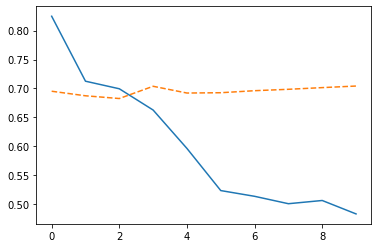

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt
plt.plot(train_stats['train_loss'])
plt.plot(train_stats['val_loss'], linestyle='--')

In [ ]:
train_stats

{'train_loss': [0.8249399427211646,
  0.7124708290352966,
  0.6993603092251401,
  0.662545874263301,
  0.5960616135235989,
  0.5231097805680651,
  0.5131790358008761,
  0.5003594403917139,
  0.5059341363834612,
  0.48268841071562335],
 'val_loss': [0.6950963735580444,
  0.6872207671403885,
  0.6824717596173286,
  0.7036859840154648,
  0.691982313990593,
  0.6925237029790878,
  0.6960261762142181,
  0.6984507963061333,
  0.7013622522354126,
  0.704099640250206]}

# Discussion


1.   Try 3D CNN
2.   Only T2w data and focus on the central slices.


In [52]:
for batch in train_loader:
  res = batch
  break

In [53]:
input, label = prepare_batch(res)

In [ ]:
# debug only training 

from tqdm import tqdm

# Initiate training stats
train_stats = {'train_loss': [],
               'val_loss': [] 
               }

best_loss = 1

for epoch_i in tqdm(range(200)):

  # switch to train mode
  model.train()
  train_loss = 0

  for batch in tqdm(train_loader):
    input_cat, label = prepare_batch(batch)
    logits = model(input_cat)
    loss = criterion(logits, label)
    train_loss += loss.item()
    
    # compute gradient and do optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss = train_loss / len(train_loader)
  print('train_loss: {}.'.format(train_loss))

100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


train_loss: 0.6446661949157715.


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


train_loss: 0.5304467082023621.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.4732881784439087.


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


train_loss: 0.4736679196357727.


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


train_loss: 0.43005311489105225.


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


train_loss: 0.4360957443714142.


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


train_loss: 0.4275120496749878.


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


train_loss: 0.4083460569381714.


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


train_loss: 0.39779818058013916.


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


train_loss: 0.38932549953460693.


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


train_loss: 0.4184513986110687.


100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


train_loss: 0.3897992670536041.


100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


train_loss: 0.45868635177612305.


100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


train_loss: 0.39221104979515076.


100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


train_loss: 0.4459775984287262.


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


train_loss: 0.4289165139198303.


100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


train_loss: 0.38235563039779663.


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


train_loss: 0.41198718547821045.


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


train_loss: 0.386290967464447.


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


train_loss: 0.38990744948387146.


100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


train_loss: 0.38722342252731323.


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


train_loss: 0.35935717821121216.


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


train_loss: 0.3848331570625305.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.41885411739349365.


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


train_loss: 0.3809663653373718.


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


train_loss: 0.35094842314720154.


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


train_loss: 0.3611770570278168.


100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


train_loss: 0.39113155007362366.


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


train_loss: 0.3656623065471649.


100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


train_loss: 0.3497048020362854.


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


train_loss: 0.3721226453781128.


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


train_loss: 0.373824805021286.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.3695359528064728.


100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


train_loss: 0.3304218649864197.


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


train_loss: 0.3073960542678833.


100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


train_loss: 0.3094010055065155.


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


train_loss: 0.3098834156990051.


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


train_loss: 0.32907921075820923.


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


train_loss: 0.29857051372528076.


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


train_loss: 0.3340298533439636.


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


train_loss: 0.3388718366622925.


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


train_loss: 0.3218644857406616.


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


train_loss: 0.3520946800708771.


100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


train_loss: 0.33909234404563904.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.31668806076049805.


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


train_loss: 0.27043989300727844.


100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


train_loss: 0.2793739438056946.


100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


train_loss: 0.2866695821285248.


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


train_loss: 0.3115991950035095.


100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


train_loss: 0.30300989747047424.


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


train_loss: 0.2888309359550476.


100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


train_loss: 0.29630422592163086.


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


train_loss: 0.3253239095211029.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.3118831217288971.


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


train_loss: 0.2683110535144806.


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


train_loss: 0.3057897686958313.


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


train_loss: 0.2723771929740906.


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


train_loss: 0.29117733240127563.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.33266353607177734.


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


train_loss: 0.2780736982822418.


100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


train_loss: 0.3020974397659302.


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


train_loss: 0.2716534435749054.


  0%|          | 0/1 [00:00<?, ?it/s]